Importing necessary python libraries.

In [ ]:
import os
import pandas as pd
import sklearn
import regex as re

import tensorflow as tf
from tensorflow.keras import Model, Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import LSTM


Make sure .csv file is in the same folder as this notebook

In [81]:
print(os.getcwd())

/content/drive/My Drive/COLAB


Loading .csv data into a pandas dataframe.

In [ ]:
twitter_data=pd.read_csv('CVAssignmentDataset.csv')

In [ ]:
tweets=twitter_data['Text']
labels=twitter_data['Class']

Tweets before removing special characters and links




In [ ]:
print(tweets[:10])

0    Today, Senate Dems vote to #SaveTheInternet. P...
1    RT @WinterHavenSun: Winter Haven resident / Al...
2    RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3    RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4    RT @Vegalteno: Hurricane season starts on June...
5    RT @EmgageActionFL: Thank you to all who came ...
6    Hurricane Maria left approx $90 billion in dam...
7    RT @Tharryry: I am delighted that @RepDarrenSo...
8    RT @HispanicCaucus: Trump's anti-immigrant pol...
9    RT @RepStephMurphy: Great joining @WeAreUnidos...
Name: Text, dtype: object


Function to remove special characters and links from tweets

In [ ]:
def clean_tweet(text):
  tweet_list=[]
  for i in range(len(text)):
    tweet_list.append(' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text[i]).split()))
  return pd.DataFrame(tweet_list)


clean_tweets=clean_tweet(tweets)

Tweets after removing special characters and links

In [ ]:
print(clean_tweets[:10])

                                                   0
0  Today Senate Dems vote to SaveTheInternet Prou...
1  RT Winter Haven resident Alta Vista teacher is...
2  RT noted that Hurricane Maria has left approxi...
3  RT Meeting with Thanks for taking the time to ...
4  RT Hurricane season starts on June 1st Puerto ...
5  RT Thank you to all who came out to our Orland...
6  Hurricane Maria left approx 90 billion in dama...
7  RT I am delighted that will be voting for the ...
8  RT Trump s anti immigrant policies are hurting...
9  RT Great joining and for a roundtable in Orlan...
86460


##Vectorization layer

Instead of tokenizing and padding words separately, we use a vectorization layer in the model to handle it.

In [ ]:

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return lowercase

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 50


vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds=tf.data.Dataset.from_tensor_slices(clean_tweets)

vectorize_layer.adapt(text_ds)

##Defining the model architecture

In [ ]:
def classifier():
  model = Sequential()
  # model.add(layers.InputLayer((50,)))
  model.add(vectorize_layer)
  model.add(layers.Embedding(10000,32,input_length=50))
  # print(model.output_shape)
  model.add(layers.Conv1D(32,1))
  # print(model.output_shape)
  model.add(layers.MaxPool1D())
  # print(model.output_shape)
  model.add(layers.Bidirectional(LSTM(256,return_sequences=True)))
  # print(model.output_shape)
  model.add(layers.Dropout(0.2))
  model.add(layers.Bidirectional(LSTM(256)))
  # print(model.output_shape)
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1024,'relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(512,'relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1,'sigmoid'))
  
  return model




Instantiating model and compiling it with loss function and optimizer.

In [72]:
clf=classifier()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

We don't have test set, so we extract some values from training data for validation purpose.

In [69]:
valid_tweets=clean_tweets[40000:43000]
valid_labels=labels[40000:43000]

Training the classification model

In [73]:
history= clf.fit(clean_tweets,labels,batch_size=32,epochs=10,validation_data=(valid_tweets,valid_labels))

Epoch 1/10
2702/2702 [==============================] - 50s 16ms/step - loss: 0.5736 - accuracy: 0.6801 - val_loss: 0.4016 - val_accuracy: 0.7923
Epoch 2/10
2702/2702 [==============================] - 44s 16ms/step - loss: 0.4244 - accuracy: 0.7910 - val_loss: 0.3721 - val_accuracy: 0.8317
Epoch 3/10
2702/2702 [==============================] - 44s 16ms/step - loss: 0.3708 - accuracy: 0.8214 - val_loss: 0.2993 - val_accuracy: 0.8530
Epoch 4/10
2702/2702 [==============================] - 44s 16ms/step - loss: 0.3151 - accuracy: 0.8504 - val_loss: 0.2587 - val_accuracy: 0.8903
Epoch 5/10
2702/2702 [==============================] - 44s 16ms/step - loss: 0.2612 - accuracy: 0.8791 - val_loss: 0.1959 - val_accuracy: 0.9213
Epoch 6/10
2702/2702 [==============================] - 44s 16ms/step - loss: 0.2079 - accuracy: 0.9052 - val_loss: 0.1779 - val_accuracy: 0.9457
Epoch 7/10
2702/2702 [==============================] - 44s 16ms/step - loss: 0.1673 - accuracy: 0.9249 - val_loss: 0.1178 -

In [82]:
clf.evaluate(clean_tweets,labels)

2702/2702 [==============================] - 19s 7ms/step - loss: 0.0704 - accuracy: 0.9733


[0.07041894644498825, 0.9732824563980103]

Using model to predict classes.

In [74]:
predicted_labels=clf.predict_classes(clean_tweets)

predicted_labels=[i[0] for i in predicted_labels]
# print(predicted_labels)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Plot of model architecture and summary

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 50)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 50, 32)            320000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 50, 32)            1056      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 25, 512)           591872    
_________________________________________________________________
dropout_32 (Dropout)         (None, 25, 512)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 512)              

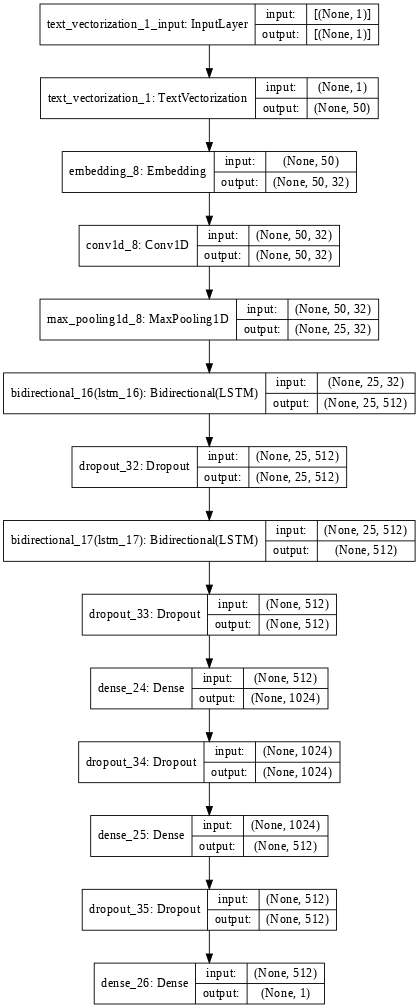

In [75]:
clf.summary()
tf.keras.utils.plot_model(clf, show_shapes=True, dpi=64)

Function for ploting accuracy and loss.

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

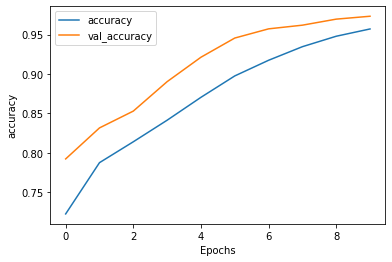

In [76]:
plot_graphs(history, 'accuracy')


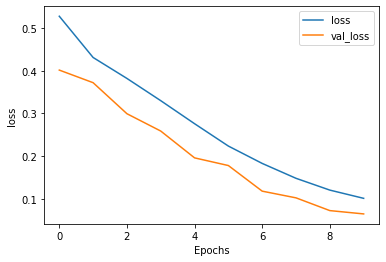

In [77]:
plot_graphs(history, 'loss')

Different metrics for evaluating the model.

In [78]:
from sklearn.metrics import matthews_corrcoef

print(" Matthews correlation coefficient: ",matthews_corrcoef(labels, predicted_labels))

 Matthews correlation coefficient:  0.9465882143969606


In [79]:
from sklearn.metrics import accuracy_score

print(" Accuracy score: ",accuracy_score(labels, predicted_labels))

 Accuracy score:  0.9732824427480916


In [80]:
from sklearn.metrics import confusion_matrix

print(" Confusion_matrix:\n",confusion_matrix(labels, predicted_labels,normalize=None))

 Confusion_matrix:
 [[43519   873]
 [ 1437 40631]]


True Positive: 43519

False Positive: 873

True Negative: 40631

False Negative: 1437